In [188]:
import msgpack as mp
import msgpack_numpy as mpn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.join(os.getcwd(), ".."))
from support.generate_ar_data import *
from support.pd_support import *
from support.calculations_support import *

In [189]:
#data path
_folder_name = "60bpm_forward_t2"

_base_pth = r"C:\Users\CMC\Documents\openposelibs\pose\skateboard_gui\test_programs\test_data"
_pth = os.path.join(_base_pth, _folder_name)

In [190]:
#calibration path
_calib_pth = os.path.join(_base_pth, "calibration3")
_kinect_calib_pth = os.path.join(_calib_pth, "kinect_calibration.msgpack")
_realsense_calib_pth = os.path.join(_calib_pth, "realsense_calibration.msgpack")
_webcam_calib_pth = os.path.join(_calib_pth, "webcam_calibration.msgpack")

#rotation matrix path
_kinect_rotmat_pth = os.path.join(_calib_pth, "kinect_rotmat.msgpack")
_realsense_rotmat_pth = os.path.join(_calib_pth, "realsense_rotmat.msgpack")
_webcam_rotmat_pth = os.path.join(_calib_pth, "webcam_rotmat.msgpack")

_kinect_video_pth = os.path.join(_pth, "kinect_color.msgpack")
_realsense_video_pth = os.path.join(_pth, "realsense_color.msgpack")
_webcam_video_pth = os.path.join(_pth, "webcam_color.msgpack")

#timestamp path
_kinect_timestamp_pth = os.path.join(_pth, "kinect_timestamp.msgpack")
_realsense_timestamp_pth = os.path.join(_pth, "realsense_timestamp.msgpack")
_webcam_timestamp_pth = os.path.join(_pth, "webcam_timestamp.msgpack")

In [191]:
#open the calibration files
with open(_kinect_calib_pth, "rb") as f:
    kinect_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(kinect_calib)
    _kinect_cam_mat = _temp[0]
    _kinect_dist = _temp[1]

with open(_realsense_calib_pth, "rb") as f:
    realsense_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(realsense_calib)
    _realsense_cam_mat = _temp[0]
    _realsense_dist = _temp[1]

with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

# open rotation matrix and org
with open(_kinect_rotmat_pth, "rb") as f:
    kinect_rotmat = mp.Unpacker(f, object_hook=mpn.decode)
    _kinect_rot = next(kinect_rotmat)
    _kinect_org = next(kinect_rotmat)

with open(_realsense_rotmat_pth, "rb") as f:
    realsense_rotmat = mp.Unpacker(f, object_hook=mpn.decode)
    _realsense_rot = next(realsense_rotmat)
    _realsense_org = next(realsense_rotmat)
    
with open(_webcam_rotmat_pth, "rb") as f:
    webcam_rotmat = mp.Unpacker(f, object_hook=mpn.decode)
    _webcam_rot = next(webcam_rotmat)
    _webcam_org = next(webcam_rotmat)

In [192]:
_k_df = get_ar_pose_data(_kinect_video_pth, _kinect_cam_mat, _kinect_dist, is_color=False, single_file=True, flip_frame=True)
_r_df = get_ar_pose_data(_realsense_video_pth, _realsense_cam_mat, _realsense_dist, is_color=False, single_file=True, flip_frame=False)
_w_df = get_ar_pose_data(_webcam_video_pth, _webcam_cam_mat, _webcam_dist, is_color=False, single_file=True, flip_frame=False)

_k_df = add_time_from_file(_k_df, _kinect_timestamp_pth)
_r_df = add_time_from_file(_r_df, _realsense_timestamp_pth)
_w_df = add_time_from_file(_w_df, _webcam_timestamp_pth)


returning dataframe
returning dataframe
returning dataframe


In [193]:
#reading mocap df
_mocap_pth = os.path.join(_base_pth, "csv_files","60bpm_forward_t2.csv")
_m_df, st_time = read_df_csv(_mocap_pth)
#getting center

_m_df["x"] = _m_df["LB_x"] + _m_df["RB_x"] + _m_df["LT_x"] + _m_df["RT_x"]
_m_df["y"] = _m_df["LB_y"] + _m_df["RB_y"] + _m_df["LT_y"] + _m_df["RT_y"]
_m_df["z"] = _m_df["LB_z"] + _m_df["RB_z"] + _m_df["LT_z"] + _m_df["RT_z"]

_m_df["x"] = _m_df["x"] / 4
_m_df["y"] = _m_df["y"] / 4
_m_df["z"] = _m_df["z"] / 4

_m_df = add_datetime_col(_m_df, st_time,_name="seconds")

In [194]:
def transform_coordinates_1(df, rotmat, org):
    df1 = df.copy( deep=True)
    for i in range(len(df)):
        val = df[["x", "y", "z"]].loc[i].values
        val = np.reshape(val, (3,1))
        _temp = val - org
        translation_correction = np.array([0.045, -0.05, 0.045]).reshape(3, 1)
        _val = rotmat.T @ _temp
        _val = _val + translation_correction
        df1["x"].loc[i] = _val[0]
        df1["y"].loc[i] = _val[1]
        df1["z"].loc[i] = _val[2]
        # df[["nx", "ny", "nz"]].loc[i] = _val.T[0]
    return df1

In [195]:
k_df = None
r_df = None
w_df = None
k_df = transform_coordinates_1(_k_df, _kinect_rot, _kinect_org)
r_df = transform_coordinates_1(_r_df, _realsense_rot, _realsense_org)
w_df = transform_coordinates_1(_w_df, _webcam_rot, _webcam_org)

c:\Users\CMC\anaconda3\envs\gs\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


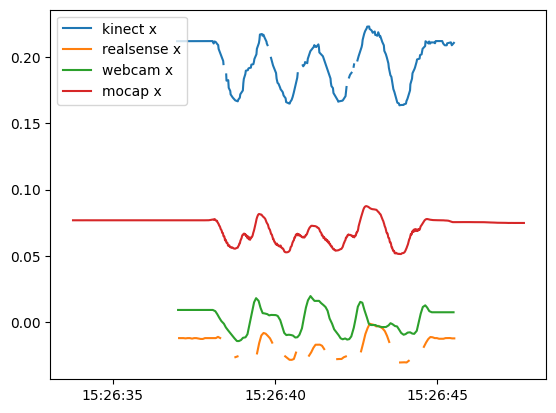

In [196]:
plt.plot(_k_df["time"], k_df["x"], label="kinect x")
plt.plot(_r_df["time"], _r_df["x"], label="realsense x")
plt.plot(_w_df["time"], _w_df["x"], label="webcam x")
plt.plot(_m_df["time"], _m_df["x"], label="mocap x")
plt.legend()

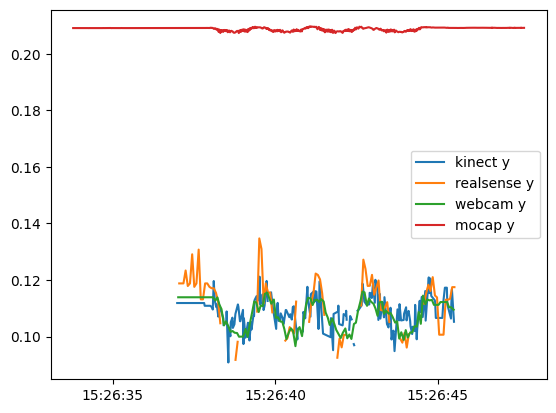

In [197]:
plt.plot(_k_df["time"], k_df["y"], label="kinect y")
plt.plot(_r_df["time"], r_df["y"], label="realsense y")
plt.plot(_w_df["time"], w_df["y"], label="webcam y")
plt.plot(_m_df["time"], _m_df["y"], label="mocap y")
plt.legend()

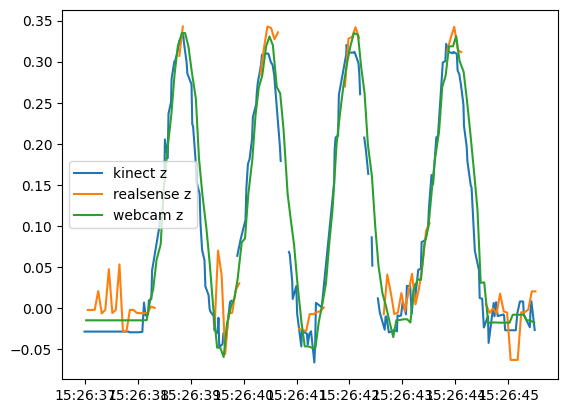

In [201]:
plt.plot(_k_df["time"], k_df["z"], label="kinect z")
plt.plot(_r_df["time"], r_df["z"], label="realsense z")
plt.plot(_w_df["time"], w_df["z"], label="webcam z")
# plt.plot(_m_df["time"], _m_df["z"], label="mocap z")
plt.legend()

In [199]:
#percentage of nan values in each column
percent_missing = k_df.isnull().sum() * 100 / len(k_df)
k_df_missing = pd.DataFrame({'column_name': k_df.columns,
                                 'percent_missing': percent_missing})
percent_missing = None

percent_missing = r_df.isnull().sum() * 100 / len(r_df)
r_df_missing = pd.DataFrame({'column_name': r_df.columns,
                                    'percent_missing': percent_missing})
percent_missing = None

percent_missing = w_df.isnull().sum() * 100 / len(w_df)
w_df_missing = pd.DataFrame({'column_name': w_df.columns,
                                    'percent_missing': percent_missing})    
percent_missing = None


In [200]:
print(k_df_missing)
print(r_df_missing)
print(w_df_missing)

         column_name  percent_missing
frame_id    frame_id         0.000000
x                  x         3.255814
y                  y         3.255814
z                  z         3.255814
yaw              yaw         3.255814
pitch          pitch         3.255814
roll            roll         3.255814
time            time         0.000000
         column_name  percent_missing
frame_id    frame_id          0.00000
x                  x         35.15625
y                  y         35.15625
z                  z         35.15625
yaw              yaw         35.15625
pitch          pitch         35.15625
roll            roll         35.15625
time            time          0.00000
         column_name  percent_missing
frame_id    frame_id              0.0
x                  x              0.0
y                  y              0.0
z                  z              0.0
yaw              yaw              0.0
pitch          pitch              0.0
roll            roll              0.0
time        